# WindLab

Este notebook exemplifica a utilização do pacote WindLab, desenvolvido para facilitar a leitura, análise e visualização de dados de instrumentos LIDAR, como Wind Cube e Zephyr. O WindLab automatiza a manipulação de dados, permitindo realizar cálculos estatísticos, gerar gráficos (como rosa dos ventos) e exportar resultados em formatos como CSV, ideal para relatórios técnicos e publicações científicas.

Neste notebook, apresentaremos exemplos práticos das principais funcionalidades do WindLab.

## Configuração do Ambiente

Esta seção fornece um guia passo a passo para criar um ambiente Conda (ou virtual) para o WindLab, instalar os módulos necessários a partir do requirements.txt e adicionar o ambiente ao Jupyter Notebook.

### Passo 1: Criar o Ambiente Conda

Primeiro, vamos criar um novo ambiente Conda chamado windlab com Python 3.8 ou superior.

In [ ]:
# Criar um novo ambiente Conda chamado 'windlab' com Python 3.10
conda create -n windlab python=3.10

# Ativar o ambiente
conda activate windlab

### Passo 2: Instalar os Pacotes Necessários

Uma vez que o ambiente esteja ativado, instale todas as dependências necessárias a partir do arquivo requirements.txt.

In [ ]:
# Instalar os pacotes necessários
pip install -r requirements.txt

### Passo 3: Adicionar o Ambiente ao Jupyter

Para trabalhar com este ambiente no Jupyter Notebook, precisamos adicioná-lo como um kernel.

In [ ]:
# Instale o pacote ipykernel:

pip install ipykernel

# Adicione o ambiente ao Jupyter:

python -m ipykernel install --user --name=windlab --display-name "Python (windlab)"

### Passo 4: Verificar a Configuração

Para verificar se tudo está configurado corretamente, execute o seguinte comando em uma célula do Jupyter Notebook:

In [1]:
import sys
print(sys.executable)

/Users/danilocoutodsouza/opt/anaconda3/envs/windlab/bin/python


### Passo 5: Adcionar Caminho do Projeto ao Ambiente

Para a utilização desse notebook, primeiro temos que ajustar o ambiente para que possamos importar os módulos do pacote. Para isso, vamos adicionar o caminho do projeto ao sys.path manualmente:

In [2]:
import sys
import os
sys.path.append(os.path.abspath(".."))

## Leitura e manipulação de dados

O primeiro passo na utilização do programa envolve a leitura de um arquivo bruto de dados e sua manipulação. Para isso, o **WindLab** utiliza as bibliotecas **Pandas** e **Xarray**:

- **Pandas** é responsável por ler o arquivo bruto tabulado do LIDAR.
- **Xarray** transforma os dados em um objeto multidimensional (3D), permitindo uma manipulação mais intuitiva e facilitada, semelhante a trabalhar com arquivos NetCDF.

No repositório, há uma pasta `testdata`, com dados para teste, referentes ao mês de agosto de 2024. Abaixo, vamos abrir o primeiro dado dessa pasta como exemplo.

In [3]:
from windlab import WindDataAccessor

ds = WindDataAccessor.windcube("../testdata/2024/WLS866-104_2024_08_01__00_00_00.rtd")
print(ds)

<xarray.Dataset> Size: 13MB
Dimensions:             (height: 7, time: 45262)
Coordinates:
  * time                (time) datetime64[ns] 362kB 2024-08-01T00:00:00.12000...
  * height              (height) int64 56B 40 50 60 70 100 120 150
Data variables:
    Wind Speed (m/s)    (height, time) float64 3MB 5.83 5.93 5.8 ... 4.0 3.94
    Wind Direction (°)  (height, time) float64 3MB 117.1 119.0 ... 108.5 106.0
    X-wind (m/s)        (height, time) float64 3MB -2.658 -2.875 ... -1.09
    Y-wind (m/s)        (height, time) float64 3MB 5.188 5.188 ... 3.788 3.788
    Z-wind (m/s)        (height, time) float64 3MB -23.04 -23.04 ... -19.98


Podemos ver que o objeto gerado possui as coordenadas **tempo** e **altura**, além de diferentes variáveis, como a **velocidade do vento**, suas componentes nos eixos **X, Y e Z**, e a **direção do vento** (em graus). 

### Importante:
A altura indicada está relativa ao nível do mar mais a altura do aparelho instalado. Por exemplo, se o Wind Cube está instalado a 100m do nível do mar, soma-se a altura do feixe de luz medido à altura de referência. 

Como o metadado do arquivo não especifica a altura de referência do aparelho, essa altura deve ser passada pelo usuário como argumento no momento de construir o dataset. Veja um exemplo abaixo:

In [4]:
ds = WindDataAccessor.windcube("../testdata/2024/WLS866-104_2024_08_01__00_00_00.rtd", reference_height=100)
print(ds)

<xarray.Dataset> Size: 13MB
Dimensions:             (height: 7, time: 45262)
Coordinates:
  * time                (time) datetime64[ns] 362kB 2024-08-01T00:00:00.12000...
  * height              (height) int64 56B 140 150 160 170 200 220 250
Data variables:
    Wind Speed (m/s)    (height, time) float64 3MB 5.83 5.93 5.8 ... 4.0 3.94
    Wind Direction (°)  (height, time) float64 3MB 117.1 119.0 ... 108.5 106.0
    X-wind (m/s)        (height, time) float64 3MB -2.658 -2.875 ... -1.09
    Y-wind (m/s)        (height, time) float64 3MB 5.188 5.188 ... 3.788 3.788
    Z-wind (m/s)        (height, time) float64 3MB -23.04 -23.04 ... -19.98


### Seleção de tempos e alturas específicas

Uma vez que os dados são carregados no formato `xarray.Dataset`, o **Xarray** oferece métodos fáceis e eficientes para selecionar intervalos de tempo e alturas específicas. Isso pode ser feito utilizando os métodos `.sel` (seleção por coordenadas) e `.isel` (seleção por índices).

#### Método `.sel`: Seleção por coordenadas

O método `.sel` permite selecionar dados com base nos valores exatos das coordenadas, como datas e alturas específicas. Por exemplo, você pode selecionar dados para um período de tempo ou uma altura específica em metros.

**Exemplo: Seleção por intervalo de tempo e altura específica**

In [5]:
ds_subset = ds.sel(time=slice('2024-08-01T00:00:00', '2024-08-01T02:00:00'), height=140)
print(ds_subset)

<xarray.Dataset> Size: 432kB
Dimensions:             (time: 9002)
Coordinates:
  * time                (time) datetime64[ns] 72kB 2024-08-01T00:00:00.120000...
    height              int64 8B 140
Data variables:
    Wind Speed (m/s)    (time) float64 72kB 5.83 5.93 5.8 nan ... 5.82 6.03 6.29
    Wind Direction (°)  (time) float64 72kB 117.1 119.0 119.7 ... 135.7 137.9
    X-wind (m/s)        (time) float64 72kB -2.658 -2.875 ... -4.313 -4.672
    Y-wind (m/s)        (time) float64 72kB 5.188 5.188 5.037 ... 4.215 4.215
    Z-wind (m/s)        (time) float64 72kB -23.04 -23.04 -23.04 ... 16.88 16.88


Neste exemplo, selecionamos o intervalo de tempo desejado usando a função `slice`, e a altura é escolhida diretamente com o valor exato (neste caso, 150 metros). Isso permite visualizar os dados apenas para aquele intervalo e altura.

#### Método `.isel`: Seleção por índices 

O método `.isel` permite a seleção de dados com base nos índices das coordenadas, ou seja, você pode escolher as posições numéricas das coordenadas de tempo e altura em vez de seus valores exatos.

In [6]:
# Selecionando os primeiros 100 passos de tempo e o primeiro índice de altura
ds_subset = ds.isel(time=slice(0, 100), height=0)
print(ds_subset)

<xarray.Dataset> Size: 5kB
Dimensions:             (time: 100)
Coordinates:
  * time                (time) datetime64[ns] 800B 2024-08-01T00:00:00.120000...
    height              int64 8B 140
Data variables:
    Wind Speed (m/s)    (time) float64 800B 5.83 5.93 5.8 nan ... 5.77 nan 5.51
    Wind Direction (°)  (time) float64 800B 117.1 119.0 119.7 ... nan 111.2
    X-wind (m/s)        (time) float64 800B -2.658 -2.875 -2.875 ... nan -1.99
    Y-wind (m/s)        (time) float64 800B 5.188 5.188 5.037 ... 5.14 nan 5.14
    Z-wind (m/s)        (time) float64 800B -23.04 -23.04 -23.04 ... -29.1 -29.1


Neste exemplo, estamos selecionando os primeiros 100 passos de tempo e o primeiro índice de altura no dataset. O primeiro índice de altura corresponde à menor altura no dataset (por exemplo, se as alturas são 50, 60 e 70 metros, o índice 0 corresponde a 50 metros).

### Plotagem da velocidade do vento em uma única altura

Para facilitar a visualização da velocidade do vento, o **WindLab** possui uma função embutida chamada `plot_variable`. Com esta função, o usuário pode facilmente gerar gráficos de variáveis, como a velocidade do vento, para um nível específico de altura.

#### Função `plot_variable`

A função `plot_variable` gera um gráfico simples da variável desejada para a altura especificada. Isso é útil quando o usuário quer visualizar rapidamente a evolução da velocidade do vento ao longo do tempo para uma única altura, sem a necessidade de realizar operações adicionais.

#### Parâmetros de entrada:
- **height** (*int*): A altura em metros para a qual a variável será plotada.
- **variable** (*str*): A variável a ser plotada (por padrão, `'Wind Speed (m/s)'`).

#### Exemplo prático:

Neste exemplo, vamos visualizar a **velocidade do vento**, a **componente X do vento** e a **direção do vento** para uma altura de 140 metros. Além da plotagem básica, o usuário pode personalizar o gráfico gerado através do objeto `ax`, que representa o eixo do gráfico. Abaixo estão algumas customizações possíveis:

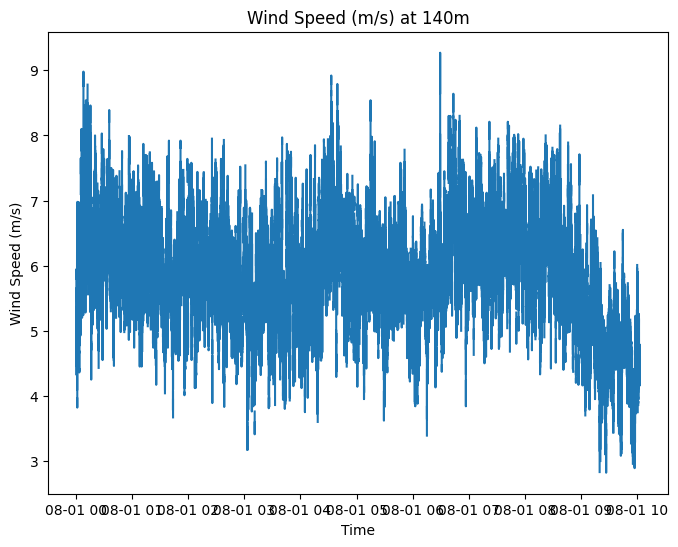

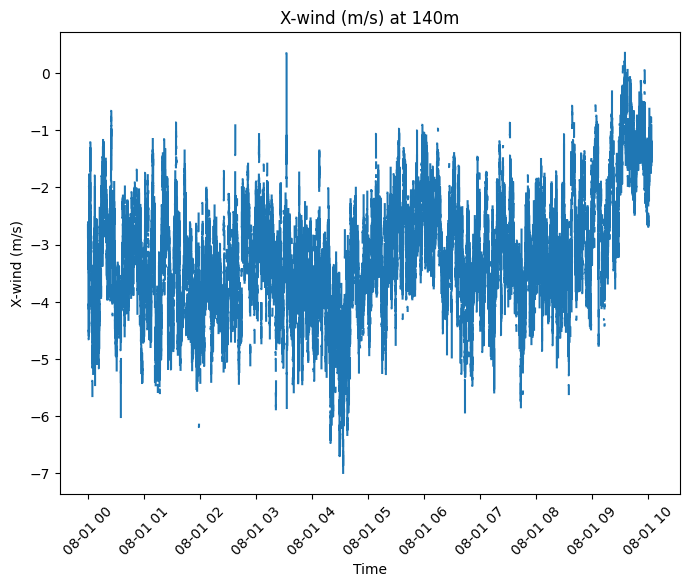

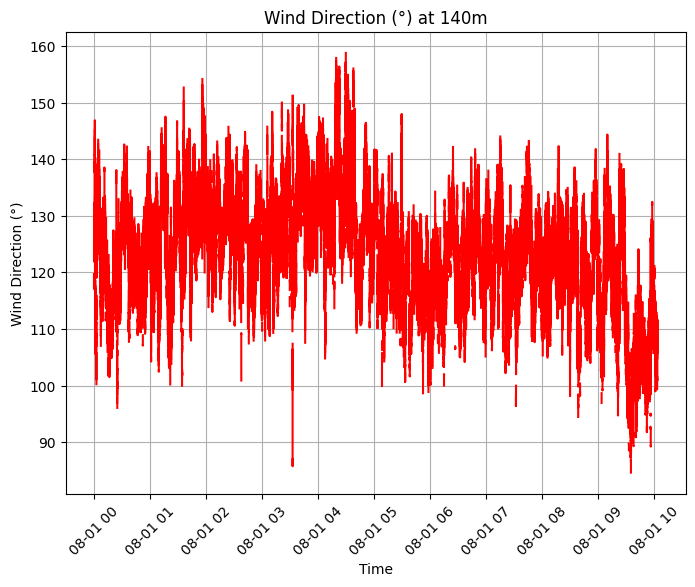

In [9]:
# Velocidade do vento
ax = ds.wind_graph.plot_variable(height=140, variable='Wind Speed (m/s)')

# Componente X
ax = ds.wind_graph.plot_variable(140, 'X-wind (m/s)')
ax.tick_params(axis='x', labelrotation=45)  # Rotaciona os rótulos do eixo X

# Direção do vento
ax = ds.wind_graph.plot_variable(140, 'Wind Direction (°)')
ax.tick_params(axis='x', labelrotation=45)
ax.grid(True)  # Ativa o grid no gráfico
line = ax.lines[0] # Capturando a linha gerada
line.set_color('red')  # Define a cor da linha para vermelho

### Obter dados de velocidade e direção do vento em formato de DataFrame

O **WindLab** oferece uma função para extrair os dados de velocidade e direção do vento para uma altura específica e convertê-los diretamente em um `pandas.DataFrame`. Isso é útil quando se deseja trabalhar com os dados em um formato mais tabular, por exemplo, para fazer cálculos adicionais ou exportar os dados para um arquivo CSV.

#### Função `get_wind_df`

A função `get_wind_df` retorna um `DataFrame` com as colunas 'Wind Speed (m/s)' e 'Wind Direction (°)' para a altura especificada.

#### Parâmetros de entrada:
- **height** (*int*): A altura em metros para a qual os dados serão extraídos.

#### Exemplo prático:

Neste exemplo, vamos obter a velocidade e a direção do vento a 40 metros e visualizar os primeiros dados retornados:

In [11]:
# Importar o módulo para exportação
from windlab.processing.utils import get_wind_df

# Obter um DataFrame com velocidade e direção do vento a 140 metros
df = get_wind_df(ds, 140)
print(df.head())

                         Wind Speed (m/s)  Wind Direction (°)
Time                                                         
2024-08-01 00:00:00.120              5.83              117.13
2024-08-01 00:00:00.920              5.93              119.00
2024-08-01 00:00:01.720              5.80              119.72
2024-08-01 00:00:02.520               NaN                 NaN
2024-08-01 00:00:03.320              5.94              121.97


### Visualização de Rosas dos Ventos

Uma funcionalidade bastante útil do **WindLab** é a possibilidade de gerar rosas dos ventos a partir dos dados de velocidade e direção do vento em diferentes alturas. A função `plot_wind_rose` permite que você visualize uma rosa dos ventos para uma altura específica, com a possibilidade de calcular médias em janelas de tempo específicas.

#### Parâmetros da Função `plot_wind_rose` 

* **`height`**: Altura (em metros) para a qual será gerada a rosa dos ventos.
* **`averaging_window`**: (Opcional) Janela de tempo para calcular a média dos dados. O formato segue as regras do Pandas, como `'1h'` para média horária, `'10T'` para média a cada 10 minutos, etc.
* **`colormap`**: (Opcional) O mapa de cores utilizado para a plotagem. O valor padrão é `'viridis'`, mas você pode escolher diferentes colormaps como `'coolwarm'`, `'plasma'`, etc.
* **`period`**: (Opcional) Um período para filtrar os dados. Pode ser um mês específico (por exemplo, `'January'`, `'February'`) ou uma estação do ano (usando os códigos meteorológicos `'DJF'` para verão austral, `'JJA'` para inverno austral, etc.).
* **Retorno**: A função retorna o objeto `WindroseAxes` para que você possa modificar ou salvar o gráfico posteriormente.

#### Exemplo 1: Plotar a Rosa dos Ventos sem Média

No exemplo abaixo, plotamos a rosa dos ventos para a altura de 140 metros sem realizar médias temporais.

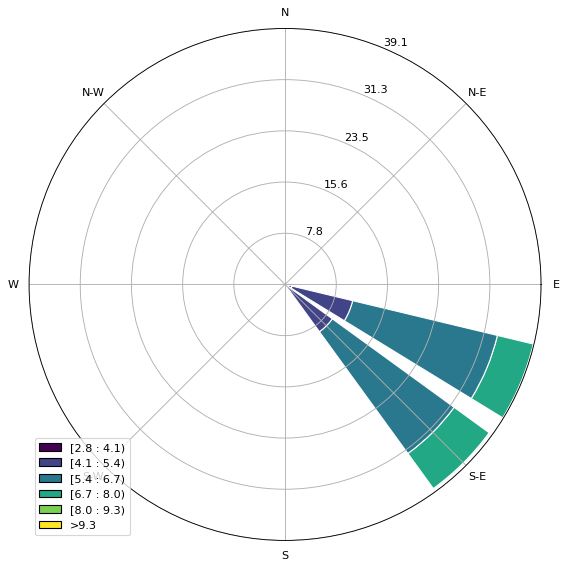

In [14]:
# Importar o Matplotlib para exibir os gráficos
import matplotlib.pyplot as plt

# Plotar a rosa dos ventos para a altura de 140 metros sem média temporal
ax = ds.wind_graph.plot_wind_rose(140)
plt.show()

#### Exemplo 2: Plotar a Rosa dos Ventos com Média Temporal 

A função `plot_wind_rose` também permite calcular médias para diferentes janelas de tempo. Abaixo, mostramos como calcular a média de velocidade e direção do vento a cada 1 hora e, em seguida, plotar a rosa dos ventos para a altura de 40 metros. Além disso, você pode modificar o título e salvar a figura posteriormente.

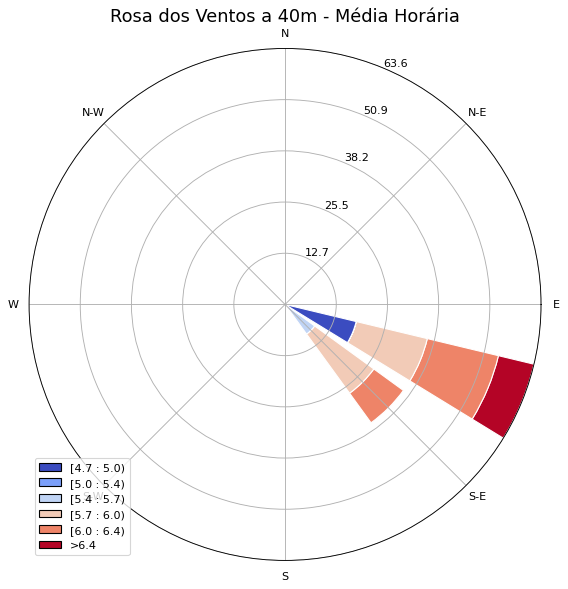

In [17]:
# Plotar a rosa dos ventos para a altura de 140 metros com média horária e um mapa de cores diferente
ax = ds.wind_graph.plot_wind_rose(140, averaging_window='1h', colormap='coolwarm')
ax.set_title("Rosa dos Ventos a 40m - Média Horária", fontsize=16)
plt.show()

# Salvar a figura
ax.figure.savefig('../figures/rosa_dos_ventos_140m_horario.png')

### Geração de Tabela de Distribuição de Vento

A função `generate_wind_distribution_table` tem como objetivo gerar uma tabela de distribuição cumulativa ou binned de vento. Cada linha pode representar a frequência cumulativa para velocidades de vento abaixo de um determinado limite ou a frequência dentro de intervalos de velocidade, enquanto cada coluna representa direções de vento agrupadas em bins de ±15° ao redor de um valor central (por exemplo, 30°, 60°, etc.).

Essa função é útil para análise de frequência de vento em diferentes direções e velocidades e pode ser usada para gerar tabelas que resumem as características do vento em diferentes alturas.

#### Parâmetros:
- **height (int)**: A altura em metros na qual calcular a distribuição de vento.
- **speed_thresholds (list, opcional)**: Lista com os limites de velocidade do vento (em m/s). O padrão é [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32].
- **direction_bins (list, opcional)**: Lista com os limites de bins de direção do vento (em graus). O padrão é [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360].
- **period (str, opcional)**: Um parâmetro opcional para filtrar dados de uma estação meteorológica específica ou mês. As estações podem ser representadas pelas siglas "DJF" (Verão), "MAM" (Outono), "JJA" (Inverno), e "SON" (Primavera). Além disso, também pode ser especificado um mês, como "January" (Janeiro), "February" (Fevereiro), etc.
- **mode (str, opcional)**: O modo de cálculo. Pode ser "accumulate" para probabilidades cumulativas ou "bins" para probabilidades distribuídas em intervalos. O padrão é "accumulate".

#### Retorno:
- **pd.DataFrame**: Um DataFrame contendo a tabela de distribuição de vento, onde as linhas são os limites de velocidade do vento (cumulativos ou intervalos) e as colunas são os bins de direção do vento, além de uma coluna "Omni" para a soma das frequências em todas as direções.

In [18]:
# Geração da tabela de distribuição de vento a 140 metros de altura
wind_distribution_table = ds.wind_table.generate_wind_distribution_table(140)

# Exibição da tabela gerada
print(wind_distribution_table)

Direction     N   NNE   ENE      E     ESE    SSE     S   SSW   WSW     W  \
Degrees      0°   30°   60°    90°    120°   150°  180°  210°  240°  270°   
0-1        0.00  0.00  0.00   0.00    0.00   0.00  0.00  0.00  0.00  0.00   
1-2        0.00  0.00  0.00   0.00    0.00   0.00  0.00  0.00  0.00  0.00   
2-3        0.00  0.00  0.00  11.11   88.89   0.00  0.00  0.00  0.00  0.00   
3-4        0.00  0.00  0.00  19.80   76.45   3.75  0.00  0.00  0.00  0.00   
4-5        0.00  0.00  0.00  15.65   72.14  12.21  0.00  0.00  0.00  0.00   
5-6        0.00  0.00  0.00   3.32   84.85  11.82  0.00  0.00  0.00  0.00   
6-7        0.00  0.00  0.00   0.84   88.83  10.33  0.00  0.00  0.00  0.00   
7-8        0.00  0.00  0.00   1.11   89.05   9.83  0.00  0.00  0.00  0.00   
8-9        0.00  0.00  0.00   0.00   82.26  17.74  0.00  0.00  0.00  0.00   
9-10       0.00  0.00  0.00   0.00  100.00   0.00  0.00  0.00  0.00  0.00   
10-11      0.00  0.00  0.00   0.00    0.00   0.00  0.00  0.00  0.00  0.00   

O arquivo que estávamos usando para teste possui, na verdade, dados apenas para as primeiras 10 horas do dia 08 de agosto de 2024. Por conta disso, a tabela de distribuição gerada anteriormente não apresentou muitos valores, o que pode dificultar uma análise mais abrangente da funcionalidade. Para podermos ter uma visão mais clara e completa do potencial dessa função, utilizaremos agora um arquivo de teste criado especificamente para este guia. Este novo arquivo contém dados fictícios para o ano de 2023, com velocidades de vento geradas a partir de uma distribuição Weibull aleatória, e uma resolução temporal de 1 hora. Com esse novo arquivo, iremos criar um novo objeto `ReadWindCubeAccessor` e construir a tabela de distribuição de vento para análise.

In [21]:
# Criando o novo objeto ReadWindCubeAccessor com o arquivo de teste fictício
ds_dummy = WindDataAccessor.windcube("../testdata/dummy_data_2023.rtd", reference_height=100)

# Gerar a tabela de distribuição de vento a 140 metros de altura para o ano de 2023
wind_distribution_table_test = ds_dummy.wind_table.generate_wind_distribution_table(140)

# Exibir a tabela gerada
print(wind_distribution_table_test)

Direction      N    NNE     ENE      E    ESE    SSE      S    SSW    WSW  \
Degrees       0°    30°     60°    90°   120°   150°   180°   210°   240°   
0-1         3.75  13.75    7.50   8.75  16.25   3.75   7.50   6.25   7.50   
1-2         4.20   9.66    8.40   7.98   8.82   7.14   9.24   8.82   7.98   
2-3         5.01   8.77   10.03  12.28   5.26   9.02   9.52   8.52   9.27   
3-4         4.90   9.44   11.62   7.99   9.62  10.89   6.53   8.53   8.17   
4-5         4.76  11.49   10.34   6.73   8.54   9.69   7.72   7.72   8.21   
5-6         4.46   8.49    7.77   9.06   8.63   6.91   9.35  10.94   8.78   
6-7         4.54   9.22    9.65   8.37   8.23   7.52   9.08   7.38   9.36   
7-8         3.12   9.20    8.16   8.90   8.31   8.75   9.94   7.72   9.20   
8-9         3.62   9.46    8.76   9.04   7.79  10.01   7.37   9.18   7.79   
9-10        4.98   9.37    8.46  10.88   9.21   8.01   7.40   8.46   8.01   
10-11       6.19   7.56    7.73   8.08   7.56   7.04  10.31   9.28   9.62   

#### Exemplo de Uso: Filtrando por Mês ou Estação 
Além de gerar a tabela de distribuição para o conjunto de dados completo, podemos também filtrar por um período específico, como um mês ou uma estação do ano. 

##### Exemplo: Filtrando por Mês

In [24]:
# Gerar a tabela de distribuição de vento para o mês de Janeiro
wind_distribution_january = ds_dummy.wind_table.generate_wind_distribution_table(140, period='January')
print(wind_distribution_january)

Direction      N    NNE    ENE       E    ESE    SSE      S    SSW     WSW  \
Degrees       0°    30°    60°     90°   120°   150°   180°   210°    240°   
0-1         0.00   0.00  16.67    0.00  16.67   0.00  16.67  16.67    0.00   
1-2         7.69  11.54   7.69    7.69   0.00   3.85  11.54   7.69    3.85   
2-3         7.41   0.00  11.11    0.00   7.41  14.81  11.11   7.41   11.11   
3-4         2.22  11.11  11.11    8.89  11.11   6.67   4.44  15.56    8.89   
4-5         4.76  14.29   9.52    4.76   7.94  14.29   6.35   7.94    3.17   
5-6         6.00  10.00   8.00   12.00   4.00   4.00   6.00  10.00   12.00   
6-7         2.04   6.12  12.24   10.20   6.12   6.12  10.20   8.16   12.24   
7-8         3.92  13.73   5.88    9.80   7.84   5.88   7.84   9.80    5.88   
8-9         4.11  13.70   9.59    6.85  10.96   6.85   8.22  15.07    2.74   
9-10        9.52   7.94   9.52   11.11   3.17   3.17   6.35   6.35    7.94   
10-11       9.52   2.38   9.52   14.29   7.14   4.76   4.76  14.

##### Exemplo: Filtrando por Estação (Verão)

In [25]:
# Gerar a tabela de distribuição de vento para o verão (Dezembro, Janeiro, Fevereiro)
wind_distribution_summer = ds_dummy.wind_table.generate_wind_distribution_table(140, period='DJF')
print(wind_distribution_summer)

Direction      N    NNE    ENE      E    ESE    SSE      S    SSW    WSW  \
Degrees       0°    30°    60°    90°   120°   150°   180°   210°   240°   
0-1         5.56   5.56   5.56   5.56  22.22   5.56   5.56   5.56  11.11   
1-2         3.23  11.29   8.06   4.84  11.29   1.61   8.06  11.29   8.06   
2-3         3.41   4.55  12.50   6.82   2.27   9.09  11.36  10.23  10.23   
3-4         2.63   7.02  11.40   6.14  11.40  14.04   4.39  11.40   7.02   
4-5         5.45  12.73  10.30   5.45   8.48  10.91   7.27   5.45   6.67   
5-6         6.83   9.94   6.83   9.94   7.45   8.70   7.45   9.94   8.70   
6-7         3.59   8.38   9.58   7.78   5.99   7.78  10.18   4.79  12.57   
7-8         2.44   9.15   7.93  12.20   8.54   7.32   8.54   9.76   7.32   
8-9         3.19  10.11   8.51  10.11   8.51   7.98   5.85  10.64   6.38   
9-10        7.23  10.24  10.84  10.84   6.02   4.82   8.43   6.02   7.23   
10-11       7.69   6.15  10.77   7.69   9.23   4.62   6.15  11.54   7.69   
11-12       

Também é possível fazer o gráfico da rosa dos ventos para um mês ou estação específico:

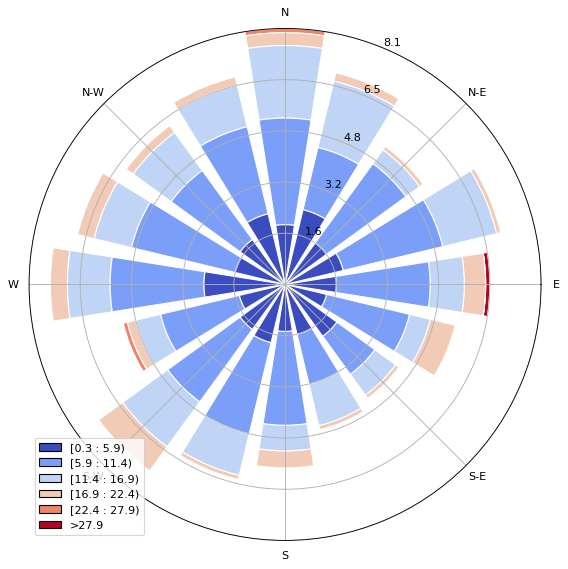

In [27]:
# Plotar a rosa dos ventos para 140 metros no mês de janeiro
ax = ds_dummy.wind_graph.plot_wind_rose(140, colormap='coolwarm', period='January')
plt.show()

#### Exemplo de Uso: Usando bins ao invés de valores acumulados

Nesse caso, o uso do argumento 'mode' em conjunto com a opção 'bins' faz com que cada linha represente a frequência relativa de ocorrência de valores entre os limites determinados na primeira coluna, sendo que o valor da esquerda é incluído, enquanto que os valores têm que ser menores que o valor à direita. 

Por exemplo, se o intervalo for `2-3`, isso significa que estamos considerando a frequência de ocorrência de velocidades de vento maiores ou iguais a 2 m/s e menores que 3 m/s. Cada coluna da tabela representa um bin de direção do vento, com cada valor indicando a porcentagem de ocorrência relativa àquela direção específica dentro do intervalo de velocidade.

A tabela gerada com o modo 'bins' é útil para entender a distribuição do vento em diferentes faixas de velocidade e direções, permitindo uma análise detalhada dos padrões de vento em uma determinada altura.

In [29]:
# Definir opções para mostrar todas as linhas e colunas
wind_distribution_bins = ds_dummy.wind_table.generate_wind_distribution_table(140, mode='bins')
print(wind_distribution_bins)

Direction      N    NNE     ENE      E    ESE    SSE      S    SSW    WSW  \
Degrees       0°    30°     60°    90°   120°   150°   180°   210°   240°   
0-1         3.75  13.75    7.50   8.75  16.25   3.75   7.50   6.25   7.50   
1-2         4.20   9.66    8.40   7.98   8.82   7.14   9.24   8.82   7.98   
2-3         5.01   8.77   10.03  12.28   5.26   9.02   9.52   8.52   9.27   
3-4         4.90   9.44   11.62   7.99   9.62  10.89   6.53   8.53   8.17   
4-5         4.76  11.49   10.34   6.73   8.54   9.69   7.72   7.72   8.21   
5-6         4.46   8.49    7.77   9.06   8.63   6.91   9.35  10.94   8.78   
6-7         4.54   9.22    9.65   8.37   8.23   7.52   9.08   7.38   9.36   
7-8         3.12   9.20    8.16   8.90   8.31   8.75   9.94   7.72   9.20   
8-9         3.62   9.46    8.76   9.04   7.79  10.01   7.37   9.18   7.79   
9-10        4.98   9.37    8.46  10.88   9.21   8.01   7.40   8.46   8.01   
10-11       6.19   7.56    7.73   8.08   7.56   7.04  10.31   9.28   9.62   

### Geração de Tabela de Cobertura de Dados

A função `generate_data_coverage_table` gera uma tabela de cobertura de dados que verifica a quantidade de dados faltantes ao longo do tempo. Cada linha da tabela representa um mês, enquanto cada coluna representa um dia do mês. A célula correspondente mostra a porcentagem de cobertura de dados disponível para aquela combinação de mês e dia.

Além disso, a função possui um argumento opcional `plot` que, quando definido como `True`, gera um gráfico visual da cobertura de dados, semelhante ao apresentado na imagem anterior. Esse gráfico utiliza um heatmap para mostrar visualmente a presença (ou ausência) de dados ao longo do tempo, facilitando a análise rápida de lacunas na coleta de dados.

Essa funcionalidade é extremamente útil para verificar a qualidade dos dados antes de realizar qualquer análise mais detalhada, garantindo que não existam grandes períodos com falta de dados.

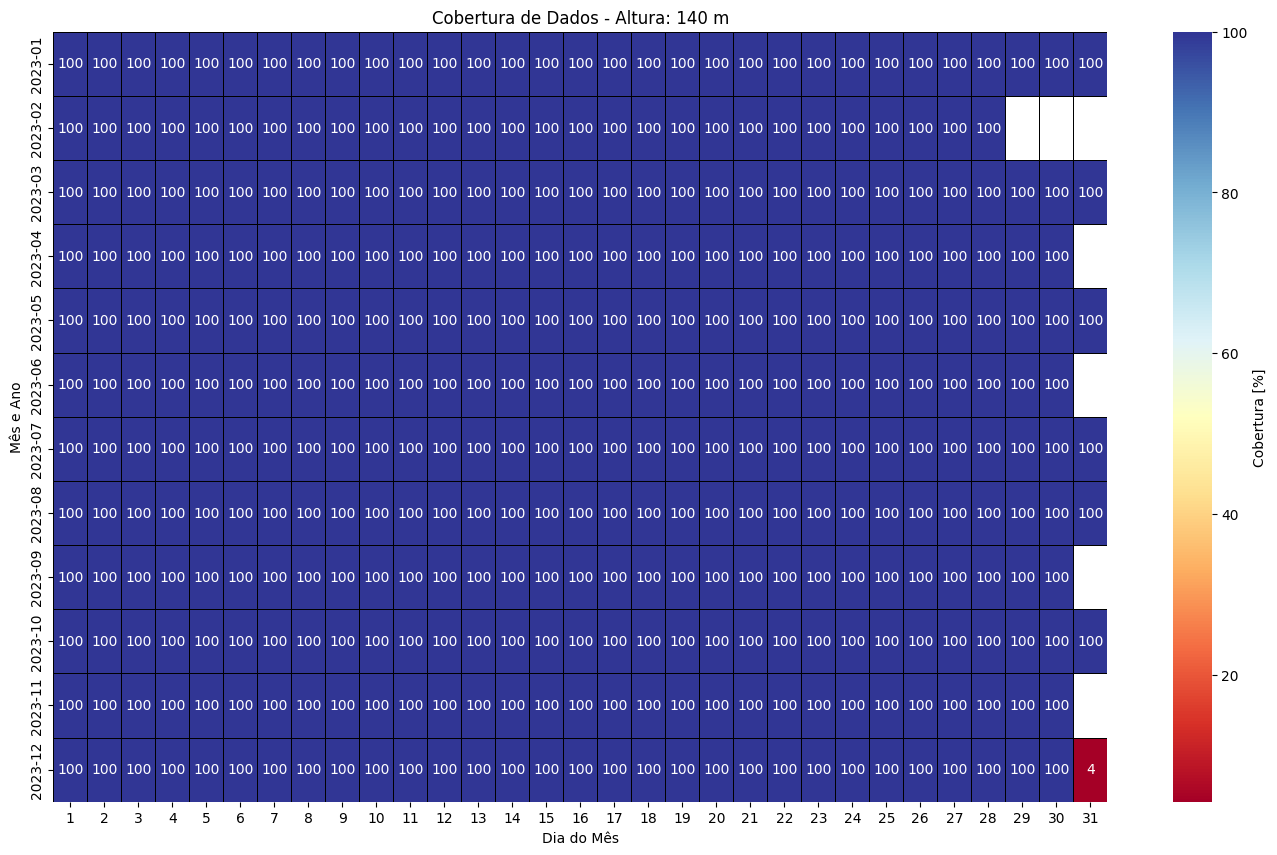

(<Axes: title={'center': 'Cobertura de Dados - Altura: 140 m'}, xlabel='Dia do Mês', ylabel='Mês e Ano'>, day         1      2      3      4      5      6      7      8      9      10  \
month                                                                           
2023-01  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0   
2023-02  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0   
2023-03  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0   
2023-04  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0   
2023-05  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0   
2023-06  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0   
2023-07  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0   
2023-08  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0   
2023-09  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0   
202

In [30]:
coverage_table = ds_dummy.wind_table.generate_data_coverage_table(140, plot=True)
print(coverage_table)

### Geração de Tabela de Velocidade Média do Vento por Hora e Mês

A função `generate_average_wind_speed_table` gera uma tabela contendo os valores médios da velocidade do vento para cada hora do dia, separados por mês, além de agrupamentos sazonais (verão, outono, inverno e primavera) e uma média global. Cada linha da tabela representa uma hora do dia, enquanto cada coluna representa um mês ou um agrupamento sazonal.

A última linha da tabela representa a média mensal de velocidade do vento para cada coluna. A função também possui um argumento opcional `plot`, que, quando definido como `True`, cria um gráfico visual da tabela. As cores do gráfico representam a razão entre a velocidade média do vento e a velocidade máxima, facilitando a interpretação dos padrões sazonais e diários da velocidade do vento.

Essa funcionalidade é útil para identificar padrões de vento ao longo do dia e das estações do ano, proporcionando uma visão detalhada dos comportamentos de vento em diferentes períodos.



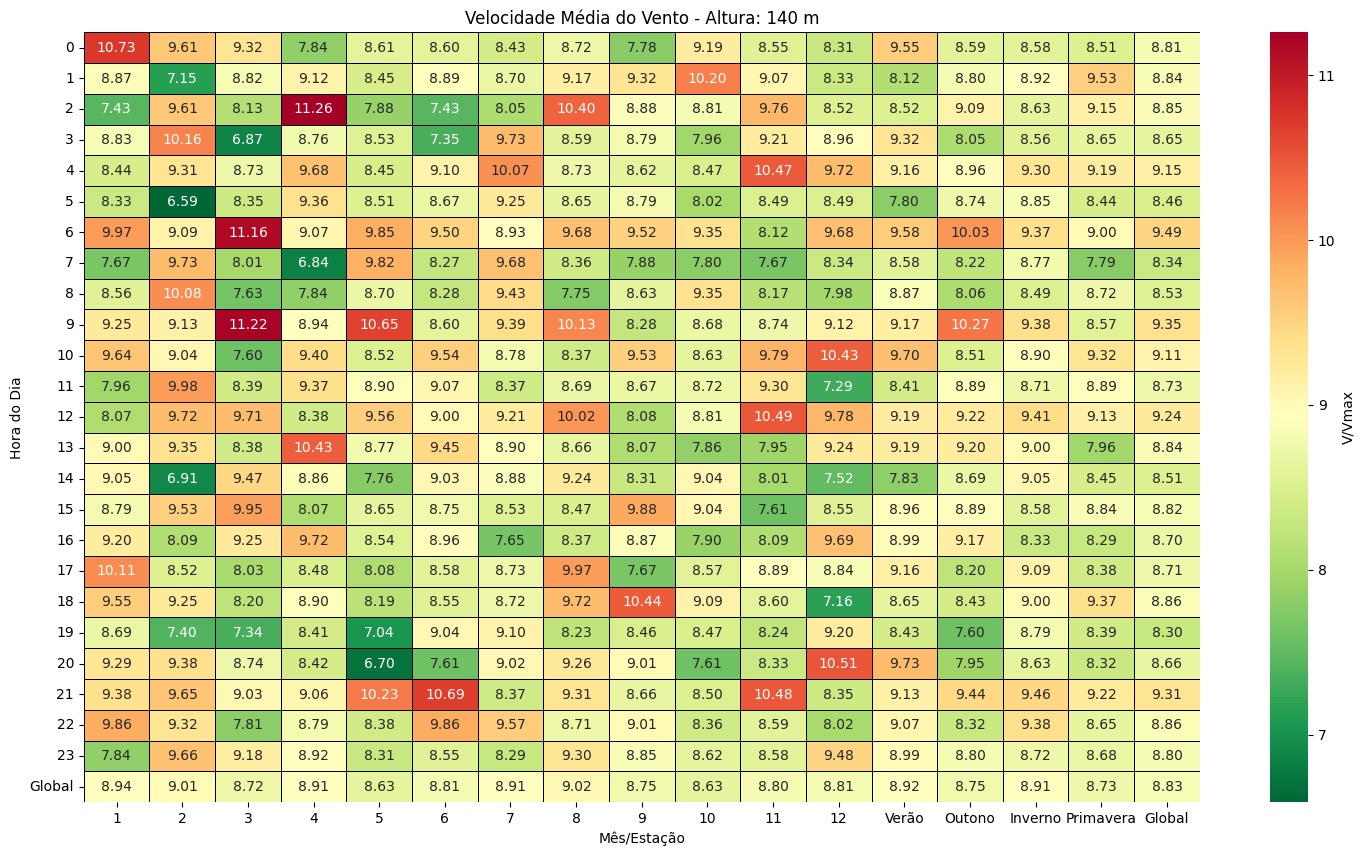

(<Axes: title={'center': 'Velocidade Média do Vento - Altura: 140 m'}, xlabel='Mês/Estação', ylabel='Hora do Dia'>, month       1      2      3      4      5      6      7      8      9     10  \
hour                                                                           
0       10.73   9.61   9.32   7.84   8.61   8.60   8.43   8.72   7.78   9.19   
1        8.87   7.15   8.82   9.12   8.45   8.89   8.70   9.17   9.32  10.20   
2        7.43   9.61   8.13  11.26   7.88   7.43   8.05  10.40   8.88   8.81   
3        8.83  10.16   6.87   8.76   8.53   7.35   9.73   8.59   8.79   7.96   
4        8.44   9.31   8.73   9.68   8.45   9.10  10.07   8.73   8.62   8.47   
5        8.33   6.59   8.35   9.36   8.51   8.67   9.25   8.65   8.79   8.02   
6        9.97   9.09  11.16   9.07   9.85   9.50   8.93   9.68   9.52   9.35   
7        7.67   9.73   8.01   6.84   9.82   8.27   9.68   8.36   7.88   7.80   
8        8.56  10.08   7.63   7.84   8.70   8.28   9.43   7.75   8.63   9.35   
9   

In [31]:
average_wind_speed_table = ds_dummy.wind_table.generate_average_wind_speed_table(140, plot=True)
print(average_wind_speed_table)
plt.show()

### Cálculo do desvio padrão da velocidade do vento e remoção de tendência

O **WindLab** oferece uma função útil para calcular o desvio padrão da velocidade do vento, após remover tendências dos dados. Essa operação é particularmente útil para identificar a variabilidade do vento em diferentes alturas e durante diferentes intervalos de tempo, à partir de uma série estacionária.

#### Função `compute_std_detrended_data`

Essa função realiza o cálculo do desvio padrão para uma variável (por padrão, a velocidade do vento) em uma altura específica, utilizando uma janela deslizante para suavizar as variações e remover tendências de longo prazo.

#### Parâmetros de entrada:
- **height** (*int*): Altura em metros para a qual o desvio padrão será calculado.
- **variable** (*str*): Nome da variável para a qual o cálculo será realizado (o padrão é 'Wind Speed (m/s)').
- **window_size** (*int*): Tamanho da janela deslizante (em número de passos no tempo) para o cálculo do desvio padrão. O padrão é 600 passos no tempo, mas pode ser ajustado conforme necessário.

#### Exemplo prático:

Abaixo, calculamos o desvio padrão com remoção de tendência para a velocidade do vento a 40 metros de altura e, em seguida, plotamos o resultado ao longo do tempo.

In [ ]:
# Calcular o desvio padrão com remoção de tendência para a velocidade do vento a 140 metros
std_detrended_ws140m = ds_accessor.compute_std_detrended_data(140, 'Wind Speed (m/s)')

# Importar biblioteca de plotagem
import matplotlib.pyplot as plt

# Plotar o desvio padrão ao longo do tempo
plt.figure(figsize=(8,6))
plt.plot(dataset.time.values, std_detrended_ws140m.values, c='#c1121f')
plt.title('Desvio Padrão da Velocidade do Vento com Tendência Removida a 140m', fontsize=14)
plt.xlabel('Tempo', labelpad=10, fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Exemplo: Cálculo do desvio padrão com remoção de tendência e plotagem da velocidade do vento a 140 metros

Agora, vamos plotar a série temporal da velocidade do vento real e do desvio padrão calculado para podermos comparar visualmente ambas as séries

In [ ]:
# Calcular o desvio padrão com remoção de tendência para a velocidade do vento a 140 metros
std_detrended_ws140m = ds_accessor.compute_std_detrended_data(140, 'Wind Speed (m/s)')

# Velocidade real a 140 metros
ws140m = dataset["Wind Speed (m/s)"].sel(height=140)
print(ws140m)

# Importar biblioteca de plotagem
import matplotlib.pyplot as plt

# Plotar o desvio padrão ao longo do tempo junto com a velocidade do vento original
plt.figure(figsize=(8,6))
plt.plot(dataset.time.values, ws140m.values, c='#003049', label='Velocidade do Vento a 140m')
plt.plot(dataset.time.values, (std_detrended_ws140m + ws140m.mean()).values, c='#c1121f', label='Velocidade com Desvio Padrão Detrended')
plt.title('Desvio Padrão da Velocidade do Vento com Tendência Removida a 140m', fontsize=14)
plt.xlabel('Tempo', labelpad=10, fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.show()